In [ ]:
### Author : Emanuele Migliaccio
### Date   : June 2024
### Description : Credit Spread Estimation based on Macroeconomic and Climate Factors and Copula Simulations


import pandas as pd
import numpy as np
import Yield_Curve_Functions as ycf
import statsmodels.api as sm
from scipy.stats import norm
import yfinance as yf
import copulas
from copulas.multivariate import GaussianMultivariate
import matplotlib.pyplot as plt


R = 0.4 # Recovery Rate


/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Load CDS from csv file and check unique companies
cds_data = pd.read_csv('/Users/emanuelemigliaccio/Climate-Risk-Project/data/cds.csv')
cds_data['Company'].unique()

/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_1009/2503580804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_cds['Date'] = pd.to_datetime(company_cds['Date'])


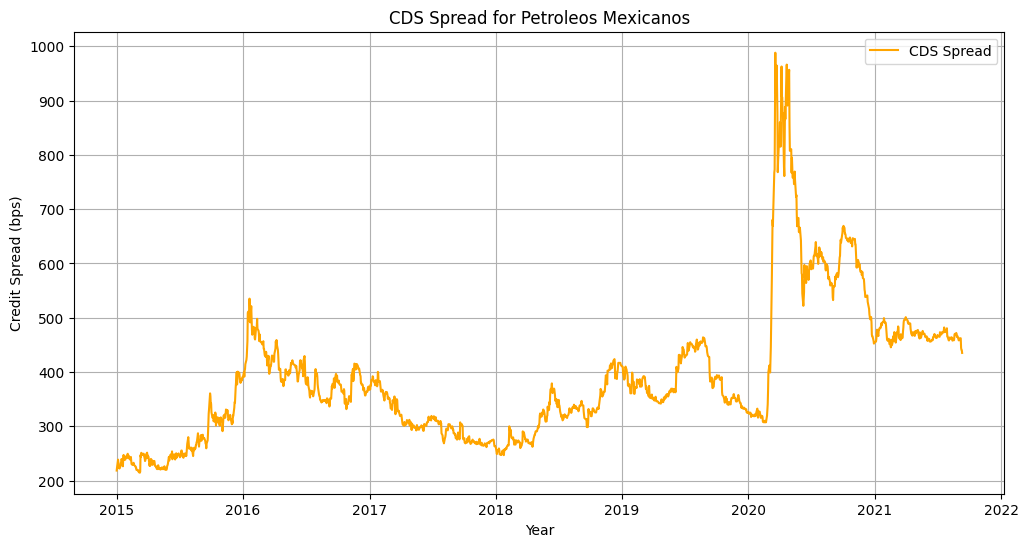

In [84]:
# Plot the time series of CDS spreads for Petroleos Mexicanos
company_cds = cds_data[cds_data['Company'] == 'Petroleos Mexicanos']
company_cds['Date'] = pd.to_datetime(company_cds['Date'])
company_cds.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(company_cds.index, company_cds['PX10'], label='CDS Spread', color='orange')
plt.title('CDS Spread for Petroleos Mexicanos')
plt.xlabel('Year')
plt.ylabel('Credit Spread (bps)')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Estimate hazard rate for Petroleos Mexicanos using CDS 10Y spreads
cds_company = cds_data[cds_data['Company'] == 'Petroleos Mexicanos'].copy()
cds_company = cds_company.drop(columns=['Ticker','Company'])
cds_company = cds_company.set_index('Date')
cds_company1y = cds_company['PX10']
cds_company1y = cds_company1y / 10000  # Convert bps to decimal
lambda_1y = cds_company1y / (1 - R)  # Hazard rate estimation


In [85]:
# Calculate Through-The-Cycle 1-Year PD using average hazard rate
pd_1y_daily = 1.0 - np.exp(-lambda_1y)
pd_1y_daily.index = pd.to_datetime(pd_1y_daily.index)
pd_1y_yearly = pd_1y_daily.groupby(pd_1y_daily.index.year).mean()
pd_TTC = pd_1y_yearly.mean()
print(f'Through-The-Cycle 1-Year PD for Petroleos Mexicanos: {pd_TTC:.4%}')

Through-The-Cycle 1-Year PD for Petroleos Mexicanos: 6.2965%


In [60]:
# Data preparation for climate data frame : Scenario SSP1 - 1.9

IPCC_CSV_PATH = "/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv"

df_ssp_raw = pd.read_csv(IPCC_CSV_PATH)
df_ssp = df_ssp_raw[df_ssp_raw["Scenario"] == "SSP1 - 1.9"].copy()
df_ssp = df_ssp.set_index("Year")

In [61]:
# Interpolate climate data from 2005 to 2100 yearly
years = np.arange(2005, 2101)
df_ssp = df_ssp.reindex(years)
df_ssp.interpolate(method='linear', inplace=True)
df_ssp = df_ssp.reset_index().rename(columns={"index": "Year"})
df_ssp.head()

/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_1009/216790850.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_ssp.interpolate(method='linear', inplace=True)


,Year,Scenario,Crop demand,Energy crop demand,Livestock demand,Energy crop production,Non-energy crop production,Livestock production,Carbon price,Methane concentration,...,Carbon intensity of energy,Primary energy intensity,Final energy intensity,Final energy as a share of primary energy,final_energy_biomass,final_energy_coal,final_energy_solar,annotation,primary_energy_intensity,final_energy_intensity
0,2005,SSP1 - 1.9,3.389947e+09,NaN,238986475.6,31469668.70,3.417340e+09,2.389865e+08,0.0,1753.1600,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,Sustainability - Taking the Green Road,0.007996,0.005936
1,2006,NaN,3.467989e+09,NaN,243677329.9,36383540.82,3.496545e+09,2.436774e+08,0.0,1765.1008,...,0.258600,2.187365,1.617163,73.911847,39.146056,33.231732,0.037450,NaN,0.007875,0.005822
2,2007,NaN,3.546032e+09,NaN,248368184.2,41297412.94,3.575751e+09,2.483682e+08,0.0,1777.0416,...,0.257087,2.153667,1.585425,73.584401,40.298861,34.836964,0.058441,NaN,0.007753,0.005708
3,2008,NaN,3.624074e+09,NaN,253059038.5,46211285.06,3.654956e+09,2.530591e+08,0.0,1788.9824,...,0.255574,2.119968,1.553686,73.256955,41.451667,36.442196,0.079432,NaN,0.007632,0.005593
4,2009,NaN,3.702117e+09,NaN,257749892.8,51125157.18,3.734162e+09,2.577499e+08,0.0,1800.9232,...,0.254061,2.086270,1.521948,72.929509,42.604473,38.047428,0.100423,NaN,0.007511,0.005479


In [ ]:
# Select relevant columns for analysis
cols = ["Carbon price", "Temperature"]
df_ssp1_19 = df_ssp[["Year"] + cols].copy()


In [ ]:
# Load yield forecasting data for SSP1 scenario and preprocess it
yield_ssp1 = pd.read_csv('/Users/emanuelemigliaccio/Climate-Risk-Project/data/yield_forecasting_ssp1.csv', index_col=0)

# Interpolate yield data from 2005 to 2100 yearly
yield_ssp1 = yield_ssp1.reindex(years)
yield_ssp1.interpolate(method='linear', inplace=True)
yield_ssp1 = yield_ssp1.reset_index().rename(columns={"index": "Year"})
yield_ssp1.head()

,Year,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add yield data to climate data frame
df_ssp1_19['yield'] = yield_ssp1['10.0']
#Set Year as index
df_ssp1_19 = df_ssp1_19.set_index('Year')

In [66]:
#Standardize the variables
df_ssp1_19['z_yield'] = (df_ssp1_19['yield'] - df_ssp1_19['yield'].mean()) / df_ssp1_19['yield'].std()
df_ssp1_19['z_Carbon_Price'] = (df_ssp1_19['Carbon price'] - df_ssp1_19['Carbon price'].mean()) / df_ssp1_19['Carbon price'].std()
df_ssp1_19['z_Temperature'] = (df_ssp1_19['Temperature'] - df_ssp1_19['Temperature'].mean()) / df_ssp1_19['Temperature'].std()



In [ ]:
# Drop original columns and handle missing values
df_ssp1_19 = df_ssp1_19.drop(columns=['yield','Carbon price','Temperature'])
df_ssp1_19 = df_ssp1_19.dropna()

In [ ]:
# Calculate correlation matrix
rho = df_ssp1_19.corr()

In [ ]:
# Define macro sensitivity betas and calculate asset threshold
beta_macro_sensitive = np.array([0.20, 0.7, 0.05])
a = norm.ppf(pd_TTC)

In [ ]:
# Estimate the conditional pd using SSP 1.9 scenario
pd_conditional = norm.cdf((a - df_ssp1_19.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
lambda_conditional = -np.log(1 - pd_conditional) # Convert PD to hazard rate for 1 year
spread_conditional = lambda_conditional * (1 - R) * 10000  # Convert to bps

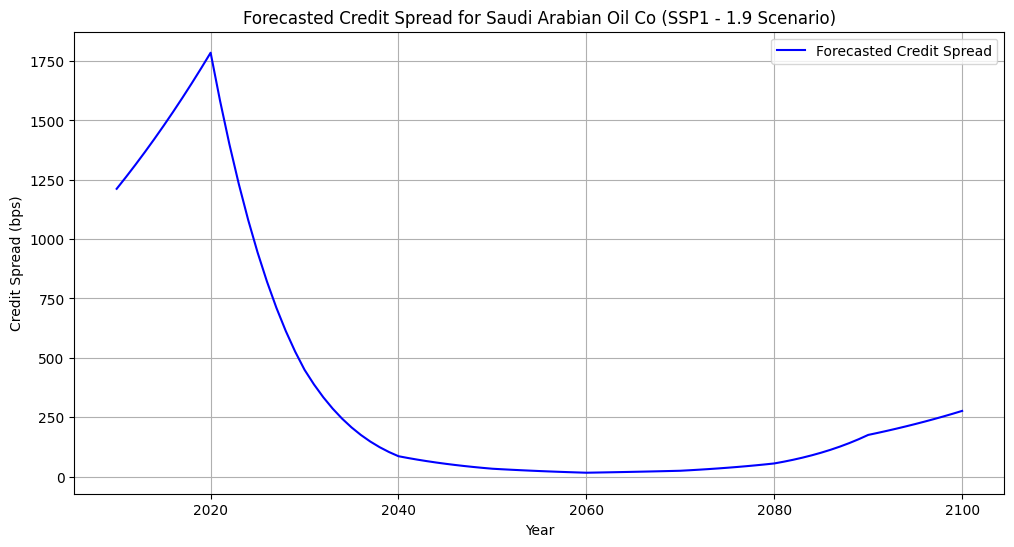

In [72]:
# Plot Credit Spread Forecasted
plt.figure(figsize=(12, 6))
plt.plot(df_ssp1_19.index, spread_conditional, label='Forecasted Credit Spread', color='blue')
plt.title('Forecasted Credit Spread for Saudi Arabian Oil Co (SSP1 - 1.9 Scenario)')
plt.xlabel('Year')
plt.ylabel('Credit Spread (bps)')
plt.legend()
plt.grid()
plt.show()

In [73]:
# Add spread to yield curve
df_ssp1_19['Credit Spread'] = spread_conditional
yield_ssp1 = yield_ssp1.set_index('Year')
df_ssp1_19['Yield with CS'] = yield_ssp1['1.0'] + df_ssp1_19['Credit Spread']/10000
df_ssp1_19['Yield wo CS'] = yield_ssp1['1.0'] 


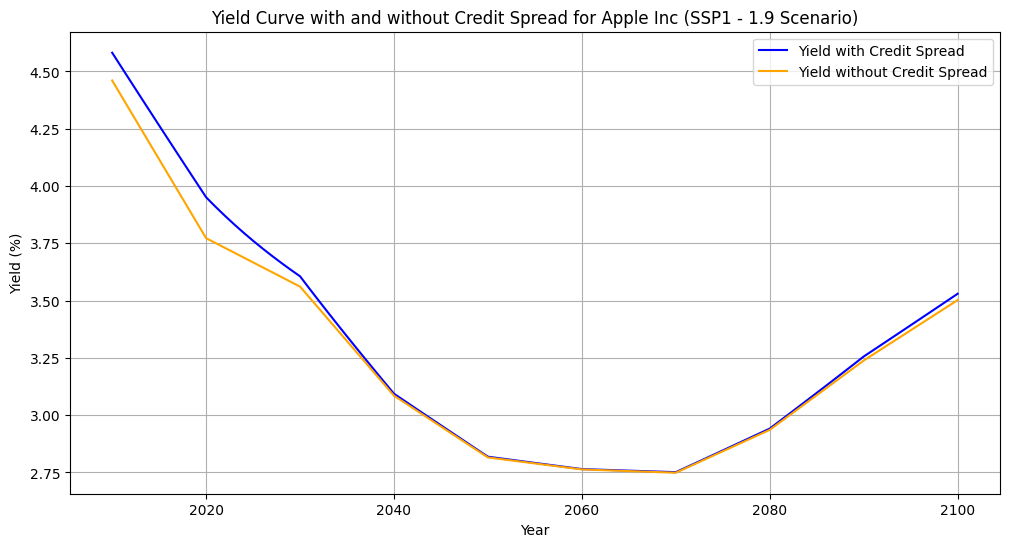

In [74]:
# Plort the yield curve with credit spread vs without credit spread
plt.figure(figsize=(12, 6))
plt.plot(df_ssp1_19.index, df_ssp1_19['Yield with CS'], label='Yield with Credit Spread', color='blue')
plt.plot(df_ssp1_19.index, df_ssp1_19['Yield wo CS'], label='Yield without Credit Spread', color='orange')
plt.title('Yield Curve with and without Credit Spread for Apple Inc (SSP1 - 1.9 Scenario)')
plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

In [75]:
# Let's try to fit a copula to fit climate variables in order to generate scenarios
df_ssp1_19_copula = df_ssp1_19[['z_yield', 'z_Carbon_Price', 'z_Temperature']]

model = GaussianMultivariate()
model.fit(df_ssp1_19_copula)

samples = model.sample(1000)


/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [ ]:
#Trying t-student copula 
# Source - https://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/303eb11b4d617b79c1257b0800744575/$FILE/t%20copula%20demarta%20mcneil.pdf

from scipy.stats import invgamma, chi2, t

#Define number of sampling points
n_samples = 10000
df = 8

mu = np.zeros(len(rho))

s = chi2.rvs(df, size=n_samples)[:, np.newaxis]
#s = invgamma.pdf(df/2,df/2) 
Z = np.random.multivariate_normal(mu, rho,n_samples)
X = np.sqrt(df/s)*Z #chi-square method
#X = np.sqrt(s)*Z #inverse gamma method

U = t.cdf(X,df)


U_df = pd.DataFrame(U)
U_df.columns = ['z_yield', 'z_Carbon_Price', 'z_Temperature']
corr_simulated_tstudent = U_df.corr()


In [ ]:
# Inverse Transform Sampling to get back to original variables

def empirical_inverse_cdf(data):
    # Build empirical CDF
    sorted_data = np.sort(data)
    def inv_cdf(u):
        idx = (u * (len(sorted_data)-1)).astype(int)
        return sorted_data[idx]
    return inv_cdf


inv_yield = empirical_inverse_cdf(df_ssp1_19_copula['z_yield'])
inv_carbon = empirical_inverse_cdf(df_ssp1_19_copula['z_Carbon_Price'])
inv_temp = empirical_inverse_cdf(df_ssp1_19_copula['z_Temperature'])

sim_yield = inv_yield(U_df['z_yield'].values)
sim_carbon = inv_carbon(U_df['z_Carbon_Price'].values)
sim_temp = inv_temp(U_df['z_Temperature'].values)

plot_df = pd.DataFrame({
    'z_yield': sim_yield,
    'z_Carbon_Price': sim_carbon,
    'z_Temperature': sim_temp
})



<Figure size 1450x1050 with 0 Axes>

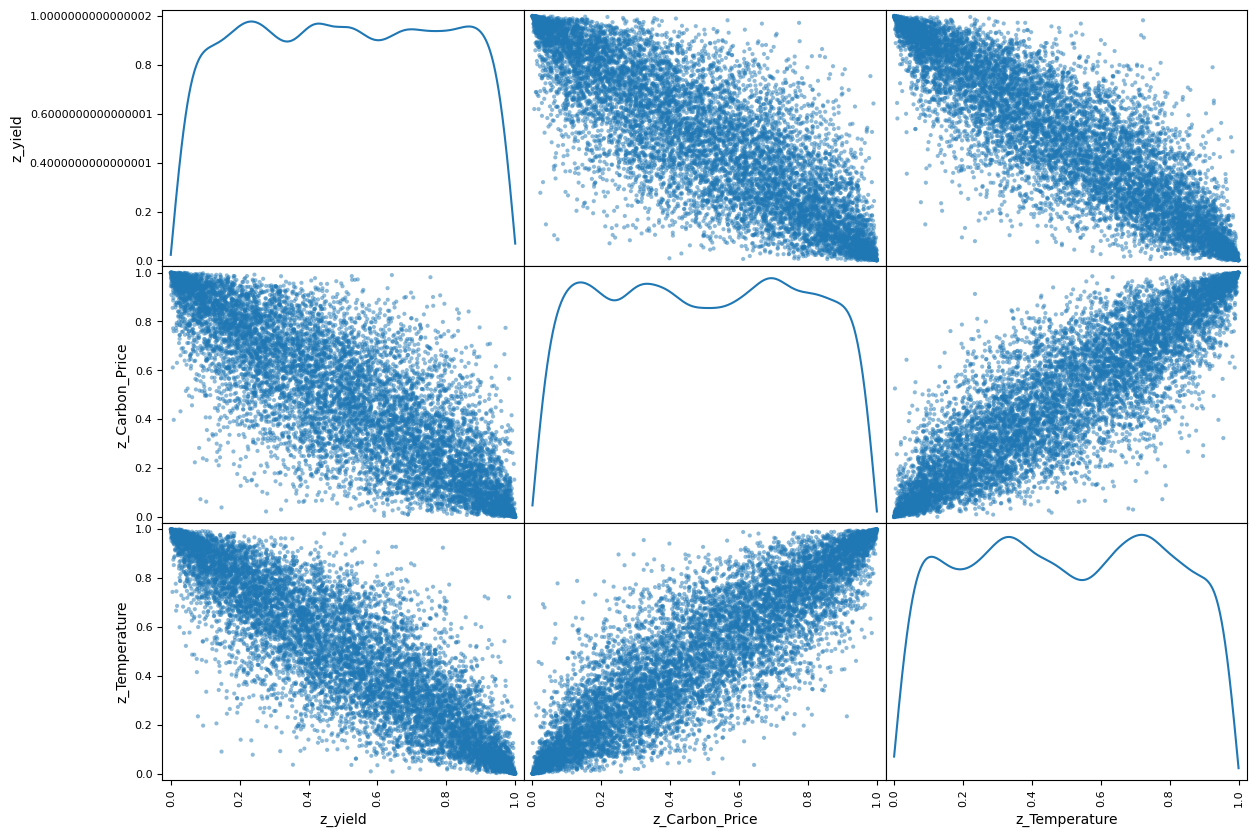

In [ ]:
# Scatter matrix plot of simulated variables

fig = plt.gcf()
fig.set_size_inches(14.5, 10.5)
pd.plotting.scatter_matrix(U_df, figsize=(14,10), diagonal = 'kde')
plt.show()


In [79]:
# Let's compare the correlation matrix of the original data vs the simulated data
corr_original = df_ssp1_19_copula.corr()
corr_simulated = samples.corr()
print("Original Correlation Matrix:\n", corr_original)
print("Simulated Correlation Matrix:\n", corr_simulated)
print("Simulated Correlation Matrix t-Student:\n", corr_simulated_tstudent)

Original Correlation Matrix:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.835947      -0.891055
z_Carbon_Price -0.835947        1.000000       0.893738
z_Temperature  -0.891055        0.893738       1.000000
Simulated Correlation Matrix:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.651863      -0.845323
z_Carbon_Price -0.651863        1.000000       0.781581
z_Temperature  -0.845323        0.781581       1.000000
Simulated Correlation Matrix t-Student:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.820759      -0.878334
z_Carbon_Price -0.820759        1.000000       0.881400
z_Temperature  -0.878334        0.881400       1.000000


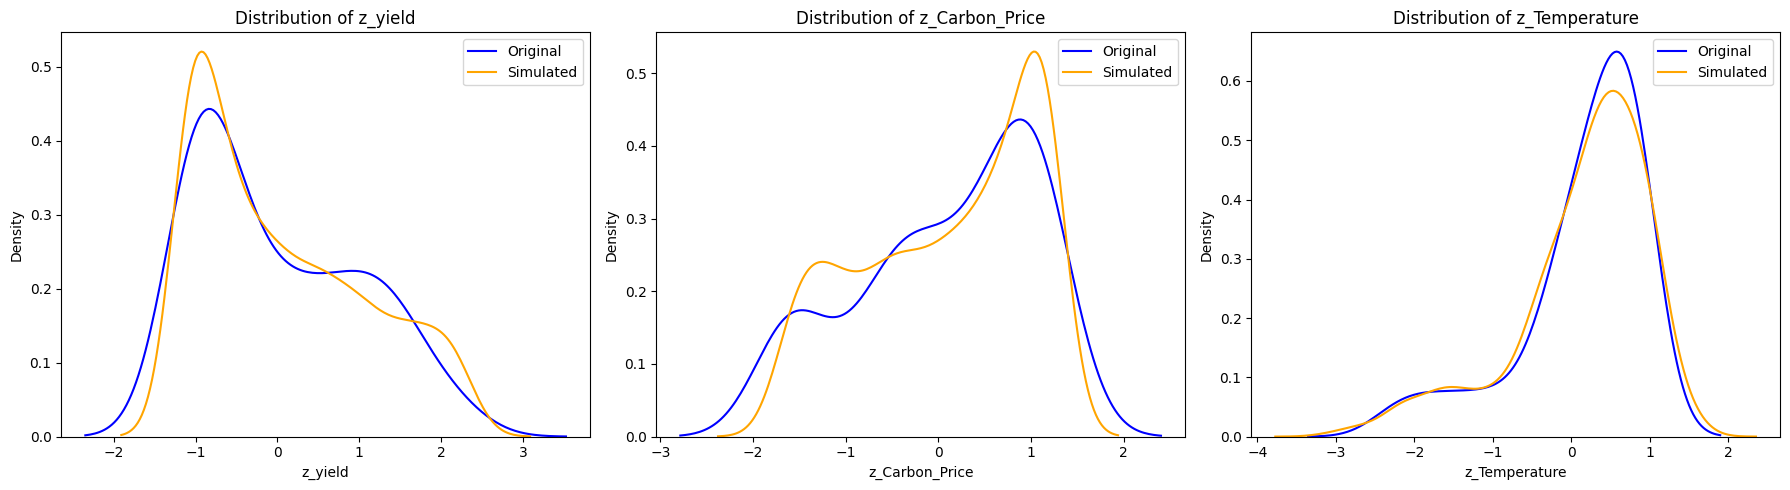

In [80]:
#Let's plot the distributions of the original vs simulated data (Gaussian Copula)
import seaborn as sns
plt.figure(figsize=(18, 5))
for i, col in enumerate(df_ssp1_19_copula.columns):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(df_ssp1_19_copula[col], label='Original', color='blue')
    sns.kdeplot(samples[col], label='Simulated', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()  

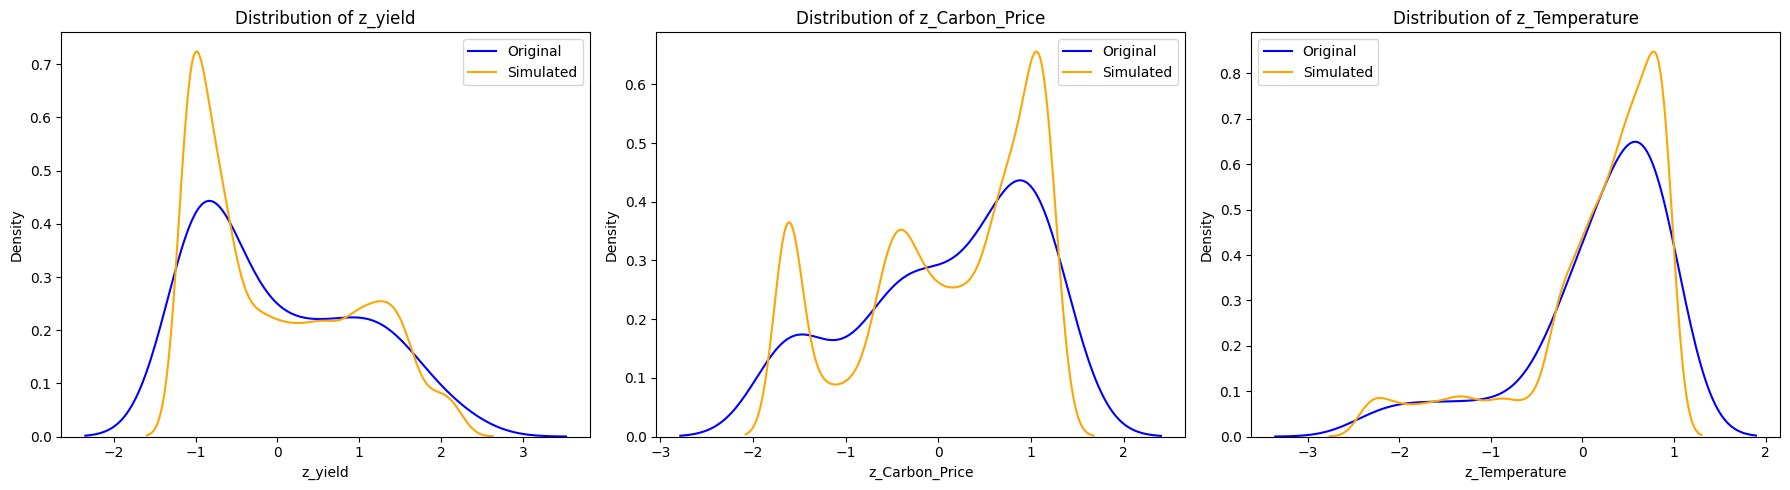

In [81]:
#Let's plot the distributions of the original vs simulated data (t-Student Copula)
import seaborn as sns
plt.figure(figsize=(18, 5))
for i, col in enumerate(df_ssp1_19_copula.columns):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(df_ssp1_19_copula[col], label='Original', color='blue')
    sns.kdeplot(plot_df[col], label='Simulated', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()  

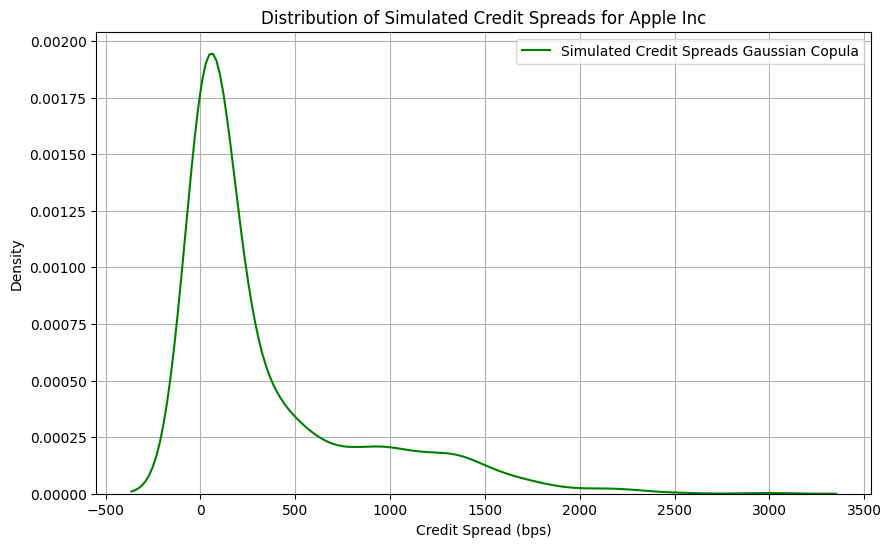

In [82]:
# Now we can use the simulated data to estimate credit spreads under different scenarios (Gaussian Copula)
for i in range(samples.shape[0]):
    simulated_row = samples.iloc[i]
    pd_conditional_sim = norm.cdf((a_saudi - simulated_row.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim = -np.log(1 - pd_conditional_sim) # Convert PD to hazard rate for 1 year
    spread_conditional_sim = lambda_conditional_sim * (1 - R) 
    # Here you can store or process the spread_conditional_sim as needed


# Plot the distribution of the simulated credit spreads
simulated_spreads = []
for i in range(samples.shape[0]):
    simulated_row = samples.iloc[i]
    pd_conditional_sim = norm.cdf((a_saudi - simulated_row.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim = -np.log(1 - pd_conditional_sim) # Convert PD to hazard rate for 1 year
    spread_conditional_sim = lambda_conditional_sim * (1 - R) * 10000  # Convert to bps
    simulated_spreads.append(spread_conditional_sim)
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_spreads, label='Simulated Credit Spreads Gaussian Copula', color='green')
plt.title('Distribution of Simulated Credit Spreads for Apple Inc')
plt.xlabel('Credit Spread (bps)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()  




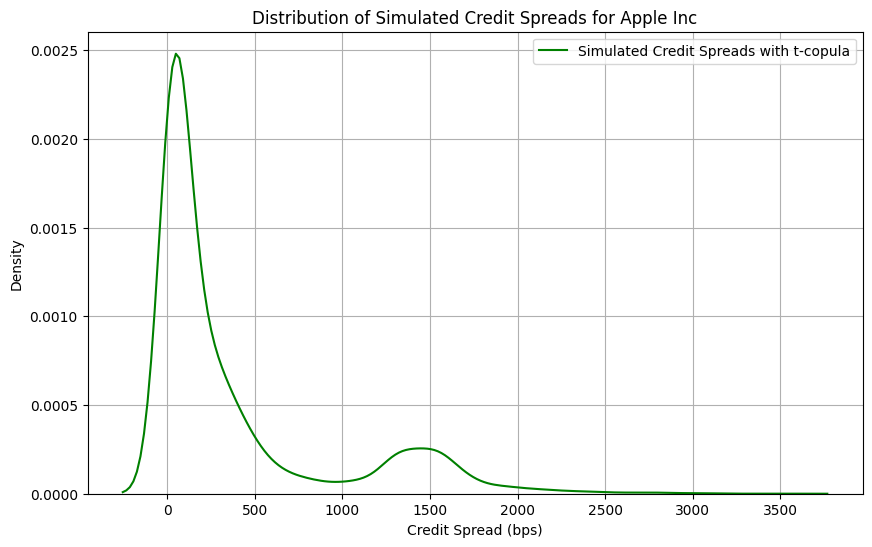

In [83]:
# Now we can use the simulated data to estimate credit spreads under different scenarios (t-Student Copula)
for i in range(samples.shape[0]):
    simulated_row_t = plot_df.iloc[i]
    pd_conditional_sim_t = norm.cdf((a_saudi - simulated_row_t.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim_t = -np.log(1 - pd_conditional_sim_t) # Convert PD to hazard rate for 1 year
    spread_conditional_sim_t = lambda_conditional_sim_t * (1 - R) 
    # Here you can store or process the spread_conditional_sim as needed


# Plot the distribution of the simulated credit spreads
simulated_spreads_t = []
for i in range(U_df.shape[0]):
    simulated_row_t = plot_df.iloc[i]
    pd_conditional_sim_t = norm.cdf((a_saudi - simulated_row_t.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim_t = -np.log(1 - pd_conditional_sim_t) # Convert PD to hazard rate for 1 year
    spread_conditional_sim_t = lambda_conditional_sim_t * (1 - R) * 10000  # Convert to bps
    simulated_spreads_t.append(spread_conditional_sim_t)
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_spreads_t, label='Simulated Credit Spreads with t-copula', color='green')
plt.title('Distribution of Simulated Credit Spreads for Apple Inc')
plt.xlabel('Credit Spread (bps)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()  


